In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from csv import reader

data = pd.read_csv('./Data/dataset.csv', delimiter='\t')

# On supprime champs non pertinents
data = data.drop(['duration', 'artist_terms_freq', 'artist_familiarity', 'artist_id', 'artist_terms_weight', 'danceability', 'energy', 'path', 'file', 'similar_artists', 'title', 'year', 'latitude', 'longitude', 'midi_name'], axis=1)

print(data.shape)

# On supprime les données sans hotttnesss ou avec hotttnesss = 0 (non calculée)
data = data.dropna(axis=0, how='any')
data = data[data['hotttnesss'] > 0]

(31034, 6)


In [12]:
print(data.head())
print(data.shape)

                                        artist_terms  key  mode  loudness  \
2  [b'hard rock' b'heavy metal' b'blues-rock' b'c...    7     1    -5.271   
5  [b'folk rock' b'singer-songwriter' b'rock' b'a...    2     1   -15.164   
6  [b'soft rock' b'blues-rock' b'pop rock' b'coun...    9     1    -8.531   
7  [b'outlaw country' b'country rock' b'southern ...    9     1    -6.291   
9  [b'hip hop' b'rap' b'funk' b'r&b' b'pop' b'sou...   11     0    -4.882   

     tempo  hotttnesss  
2  150.062    0.684136  
5  103.905    0.830423  
6  180.149    0.767728  
7  185.061    0.215080  
9  105.206    0.624425  
(13152, 6)


In [13]:
# ajout de genres principaux
data['rock'] = data['artist_terms'].apply(lambda x: int('rock' in x))
data['pop'] = data['artist_terms'].apply(lambda x: int('pop' in x))
data['rap'] = data['artist_terms'].apply(lambda x: int('rap' in x))
data['country'] = data['artist_terms'].apply(lambda x: int('country' in x))
data['classical'] = data['artist_terms'].apply(lambda x: int('classical' in x))
data['jazz'] = data['artist_terms'].apply(lambda x: int('jazz' in x))

In [14]:
# on laisse de côté le champ "artist_terms" qui est non numérique
data = data.drop(['artist_terms'], axis=1)

# on place la colonne "hotttnesss en fin de dataframe"
new_order = ['key', 'mode', 'loudness', 'tempo', 'rock', 'pop', 'rap', 'country', 'classical', 'jazz', 'hotttnesss']
data = data[new_order]

In [15]:
# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]

In [16]:
# on convertit data en array numpy
data = data.values

# on change toutes les valeurs en positif
data = np.absolute(data)

In [17]:
# on divise chaque colonne par le max de cettte colonne pour que chaque entrée soit comprise entre 0 et 1
data = data*1./np.max(data, axis=0)

In [18]:
# données d'entraînement, de test et de validation
train_start = 0
train_end = int(np.floor(0.7*n))
test_start = train_end
test_end = int(np.floor(0.9*n))
validation_start = test_end
validation_end = n

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]
data_validation = data[np.arange(validation_start, validation_end), :]

In [19]:
# on définit x et y
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]
X_validation = data_test[:, :-1]
y_validation = data_test[:, -1]

In [20]:
# nombre de paramètres pour entrée X
n_params = X_train.shape[1]

# neurones
n_neurons_1 = 2048
n_neurons_2 = 1024

# session
net = tf.InteractiveSession()

# placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_params])
Y = tf.placeholder(dtype=tf.float32, shape=[None])


In [21]:
# initialisation des poids et des biais
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# poids de la couche cachée
W_hidden_1 = tf.Variable(weight_initializer([n_params, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# poids en sortie
W_out = tf.Variable(weight_initializer([n_neurons_2, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# couches cachées
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))

# couche de sortie
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

# fonction de cout
cost = tf.reduce_mean(tf.squared_difference(out, Y))

# fonction d'optimisation (descente de gradient)
train_op = tf.train.GradientDescentOptimizer(0.005).minimize(cost)


In [22]:
# Fit neural net
batch_size = 64
training_epochs = 100


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    mse_train = []
    mse_test = []

    for e in range(training_epochs):
        print('epoch numero %i' % e)

        # Shuffle training data
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train = X_train[shuffle_indices]
        y_train = y_train[shuffle_indices]

        # Minibatch training
        for i in range(0, len(y_train) // batch_size):
            start = i * batch_size
            batch_x = X_train[start:start + batch_size]
            batch_y = y_train[start:start + batch_size]
            # Run optimizer with batch
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})

            # Show progress
            if np.mod(i, 50) == 0:
                # MSE train and test
                mse_train.append(sess.run(cost, feed_dict={X: X_train, Y: y_train}))
                mse_test.append(sess.run(cost, feed_dict={X: X_test, Y: y_test}))
                print('MSE Train: ', mse_train[-1])
                print('MSE Test: ', mse_test[-1])
                # Prediction
                pred = sess.run(out, feed_dict={X: X_test})
                
        valid = sess.run(out, feed_dict={X: X_validation})
    print("Optimisation terminée !")

epoch numero 0
MSE Train:  0.24904741
MSE Test:  0.24744934
MSE Train:  0.04297534
MSE Test:  0.042421736
MSE Train:  0.040933657
MSE Test:  0.040517952
epoch numero 1
MSE Train:  0.039736
MSE Test:  0.039393127
MSE Train:  0.038848083
MSE Test:  0.038542837
MSE Train:  0.038218256
MSE Test:  0.037985608
epoch numero 2
MSE Train:  0.037784133
MSE Test:  0.037595663
MSE Train:  0.037534237
MSE Test:  0.03735617
MSE Train:  0.037217945
MSE Test:  0.03710662
epoch numero 3
MSE Train:  0.037033405
MSE Test:  0.03696828
MSE Train:  0.036867633
MSE Test:  0.03678888
MSE Train:  0.036733247
MSE Test:  0.0366784
epoch numero 4
MSE Train:  0.036669526
MSE Test:  0.036648218
MSE Train:  0.036583778
MSE Test:  0.036531407
MSE Train:  0.03650036
MSE Test:  0.036496375
epoch numero 5
MSE Train:  0.036421407
MSE Test:  0.036411867
MSE Train:  0.03635225
MSE Test:  0.03633125
MSE Train:  0.036292505
MSE Test:  0.036261547
epoch numero 6
MSE Train:  0.03626771
MSE Test:  0.036264338
MSE Train:  0.0362

MSE Train:  0.03480616
MSE Test:  0.034920353
MSE Train:  0.03489744
MSE Test:  0.034981553
epoch numero 54
MSE Train:  0.034821685
MSE Test:  0.034956504
MSE Train:  0.034796245
MSE Test:  0.03491517
MSE Train:  0.034812976
MSE Test:  0.034924492
epoch numero 55
MSE Train:  0.03478956
MSE Test:  0.034903634
MSE Train:  0.034789216
MSE Test:  0.0349063
MSE Train:  0.0347801
MSE Test:  0.03489712
epoch numero 56
MSE Train:  0.03478614
MSE Test:  0.03492345
MSE Train:  0.034795478
MSE Test:  0.034901634
MSE Train:  0.034849625
MSE Test:  0.034994848
epoch numero 57
MSE Train:  0.03476784
MSE Test:  0.03489741
MSE Train:  0.034765564
MSE Test:  0.034909923
MSE Train:  0.03479773
MSE Test:  0.034903005
epoch numero 58
MSE Train:  0.034818932
MSE Test:  0.034978267
MSE Train:  0.034778077
MSE Test:  0.034925513
MSE Train:  0.034846846
MSE Test:  0.034930017
epoch numero 59
MSE Train:  0.034754578
MSE Test:  0.03489592
MSE Train:  0.0347606
MSE Test:  0.03488274
MSE Train:  0.034745917
MSE T

In [23]:
# analyse résultats

In [24]:
random = np.random.rand(y_test.shape[0])

In [25]:
sample =np.full(y_validation.shape, np.mean(y_validation))

In [26]:
from sklearn import metrics

In [27]:
metrics.mean_squared_error(y_validation, sample)

0.03716221568025413

In [28]:
metrics.mean_squared_error(y_validation, valid[0])

0.03474587197740862

In [29]:
test1 = np.absolute(y_validation - valid[0])
test2 =  np.absolute(y_validation - sample)

In [30]:
print(test1.mean())
print(test2.mean())

0.15586158266306072
0.16250320110518973


In [31]:
metrics.mean_squared_error(y_validation, random)

0.12282853715092318

In [32]:
np.var(y_validation)

0.03716221568025413

In [33]:
import matplotlib.pyplot as plt

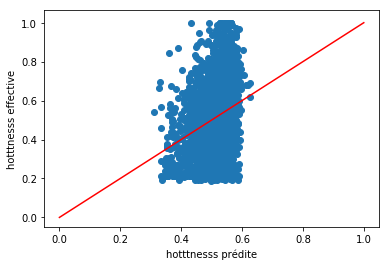

In [34]:
plt.subplot()
plt.plot([0,1], [0,1], color="r")
plt.scatter(valid[0] , y_validation)
plt.xlabel('hotttnesss prédite')
plt.ylabel('hotttnesss effective')
plt.show()